In [23]:
#!/usr/bin/env python3

# Menyesuaikan path agar dapat mengimpor modul dari direktori utama (induk)
# tanpa mengubah struktur direktori proyek
import sys
sys.path.append('..')

# Mengimpor file module untuk melakukan sync semua file
# pada direktori utama (induk)
import module

W0000 00:00:1769905792.123775  370927 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1769905792.129091  370930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769905792.143463  370939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


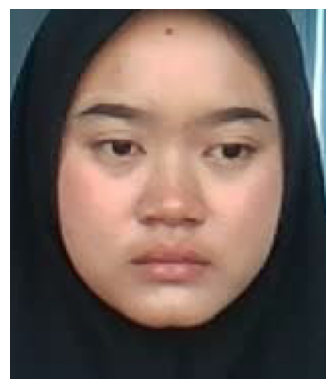

In [24]:
import os
# import glob
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from src.face.modules.face_landmark import FaceLandmark


# Menentukan file target untuk pengujian deteksi dan juga penyelarasan wajah
TARGET_FILE=os.path.join(Path.home(), "datasets", "primary-converted", "8-12-2025/aaisyah_nursalsabiil_ni_patriarti_1765168488512/q1/answer_1_15d591ce-051a-47f2-ac38-367c1e6189c7_sec.avi")

# Membaca satu frame dari berkas video sebagai sampel pengujian
ret, frame = cv2.VideoCapture(TARGET_FILE).read()

face_landmark = FaceLandmark()

face_landmark.detect(frame)
cropped_face = face_landmark.crop(frame, margin=0.2)

plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Membuat instance untuk melakukan penyelarasan wajah

In [ ]:
import cv2
import numpy as np
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarkerResult


class FaceAlignerPoints:

    # Titik mata kiri atas
    LEFT_EYE_TOP = 159

    # Titik mata kanan atas
    RIGHT_EYE_TOP = 386

    # Titik ujung hidung
    NOSE_TIP = 1

    # Titik mulut kiri
    MOUTH_LEFT = 61

    # Titik mulut kanan
    MOUTH_RIGHT = 291


class FaceAligner:
    
    def align(self, image: np.ndarray = None, landmarks: FaceLandmarkerResult = None) -> np.ndarray:
        """
        Menyelaraskan wajah dalam citra berdasarkan titik landmark yang sudah didapat.
        
        Args:
            image (np.ndarray): Citra input yang berisi wajah yang akan diselaraskan.
            landmarks (FaceLandmarkerResult): Hasil deteksi landmark wajah.
            
        Returns:
            np.ndarray: Citra wajah yang sudah diselaraskan.

        Raises:
            ValueError: Jika tidak ada wajah yang terdeteksi dalam citra.
        """
        
        # Melakukan validasi input citra untuk memastikan adalah instance dari numpy ndarray
        # Jika tidak, maka akan mengembalikan exception ValueError
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image must be a valid numpy ndarray.")
        
        # Melakukan validasi input landmark untuk memastikan adalah instance dari FaceLandmarkerResult
        # Jika tidak, maka akan mengembalikan exception ValueError
        if not isinstance(landmarks, FaceLandmarkerResult):
            raise ValueError("Input landmarks must be a valid FaceLandmarkerResult instance.")
        
        # Memastikan bahwa ada wajah yang terdeteksi dalam citra
        # Jika tidak, maka akan mengembalikan exception ValueError
        if not landmarks.face_landmarks:
            raise ValueError("No face detected in the image.")
        
        # Mengambil landmark dari wajah pertama yang terdeteksi
        landmark = landmarks.face_landmarks[0]
        
        h, w = image.shape[:2]
        
        # Mendefinisikan titik referensi untuk penyelarasan wajah
        reference_points = np.array([
            [landmark[FaceAlignerPoints.LEFT_EYE_TOP].x * w, landmark[FaceAlignerPoints.LEFT_EYE_TOP].y * h],
            [landmark[FaceAlignerPoints.RIGHT_EYE_TOP].x * w, landmark[FaceAlignerPoints.RIGHT_EYE_TOP].y * h],
            [landmark[FaceAlignerPoints.NOSE_TIP].x * w, landmark[FaceAlignerPoints.NOSE_TIP].y * h],
        ], dtype=np.float32)
        
        # Titik tujuan ini adalah posisi standar di mana titik referensi
        # harus ditempatkan setelah penyelarasan
        # Menggunakan proporsi yang lebih natural untuk wajah
        destination_points = np.array([
            [0.35 * w, 0.35 * h],  # Left eye   -> lebih ke tengah
            [0.65 * w, 0.35 * h],  # Right eye  -> lebih ke tengah
            [0.5 * w, 0.55 * h],   # Nose tip   -> sedikit di bawah mata
        ], dtype=np.float32)
        
        # Menghitung matriks transformasi afine untuk penyelarasan wajah
        # Hanya menggunakan 3 titik pertama (kedua mata dan hidung)
        # karena cv2.getAffineTransform() hanya membutuhkan 3 titik
        transformation_matrix = cv2.getAffineTransform(
            reference_points, 
            destination_points
        )
        
        # Menerapkan transformasi dengan parameter interpolasi linear
        # dan border mode replicate untuk mengisi area kosong
        aligned_face = cv2.warpAffine(image, 
                                      transformation_matrix, 
                                      (w, h),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REPLICATE)
        
        return aligned_face

Melakukan pengujian terhadap hasil penyelarasan

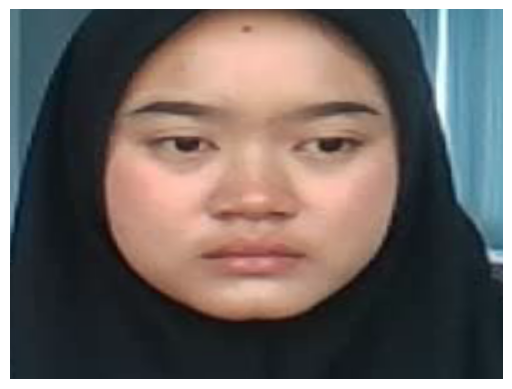

In [32]:
landmarks = face_landmark.detect(frame)

face_aligner = FaceAligner()
aligned_face = face_aligner.align(image=frame, landmarks=landmarks)

plt.imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()